In [19]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

Data source:
https://data.montgomerycountymd.gov/Public-Safety/Traffic-Violations/4mse-ku6q
* cut off data: 2022-08-15

In [3]:
df = pd.read_csv('Traffic_Violations_montgomery_county.csv')

In [4]:
# drop columns
drop_col = ['SeqID', 'Agency', 'SubAgency', 'Accident', 'Fatal', 'Commercial License','HAZMAT', 'Commercial Vehicle', 
           'Work Zone', 'State', 'VehicleType', 'Year', 'Make', 'Model', 'Color', 'Charge', 'Article', 'Driver State', 'DL State', 'Search Reason For Stop', 'Search Arrest Reason', 'Location',
           'Search Conducted', 'Search Disposition', 'Search Outcome', 'Search Reason', 'Search Type','Geolocation',
           'Latitude', 'Longitude','Description', 'Driver City', 'Arrest Type']
df = df.drop(columns = drop_col)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803695 entries, 0 to 1803694
Data columns (total 10 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   Date Of Stop             object
 1   Time Of Stop             object
 2   Belts                    object
 3   Personal Injury          object
 4   Property Damage          object
 5   Alcohol                  object
 6   Violation Type           object
 7   Contributed To Accident  bool  
 8   Race                     object
 9   Gender                   object
dtypes: bool(1), object(9)
memory usage: 125.6+ MB


In [5]:
# check null value
df.isnull().sum()

Date Of Stop               0
Time Of Stop               0
Belts                      0
Personal Injury            0
Property Damage            0
Alcohol                    0
Violation Type             0
Contributed To Accident    0
Race                       0
Gender                     0
dtype: int64

In [6]:
# convert time format
df['date_time'] = df['Date Of Stop'] + ' ' + df['Time Of Stop']
col = ['Date Of Stop', 'Time Of Stop']
df = df.drop(columns = col)
df['date_time'] = pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803695 entries, 0 to 1803694
Data columns (total 9 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Belts                    object        
 1   Personal Injury          object        
 2   Property Damage          object        
 3   Alcohol                  object        
 4   Violation Type           object        
 5   Contributed To Accident  bool          
 6   Race                     object        
 7   Gender                   object        
 8   date_time                datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(7)
memory usage: 111.8+ MB


In [7]:
# set the time to index and create new columns for year, month, day of the week and hour
df.set_index('date_time', inplace=True)
df.sort_index(inplace=True)
df['month'] = df.index.strftime('%m-%b')
df['day_of_week'] = df.index.strftime('%A')
df['year'] = df.index.strftime('%Y')
df['hour'] = df.index.strftime('%H')
df.head()

,Belts,Personal Injury,Property Damage,Alcohol,Violation Type,Contributed To Accident,Race,Gender,month,day_of_week,year,hour
date_time,,,,,,,,,,,,
2012-01-01 00:43:00,No,No,No,No,Warning,False,WHITE,M,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00


In [8]:
df['Contributed To Accident'] = np.where(df['Contributed To Accident'] == True, 1, df['Contributed To Accident'])
df['Contributed To Accident'] = np.where(df['Contributed To Accident'] == False, 0, df['Contributed To Accident'])

In [9]:
# split data
from sklearn.model_selection import train_test_split
import math
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df['Contributed To Accident'])

train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate['Contributed To Accident'])

## Data Explore

### 1. Does contributed to accident happened related to the hour? day of week? month? year?

In [10]:
hour = pd.crosstab(train.hour, train['Contributed To Accident'], normalize = 'index').sort_index(ascending=False)
day_of_week = pd.crosstab(train.day_of_week, train['Contributed To Accident'], normalize = 'index').sort_index(ascending=False)
month = pd.crosstab(train.month, train['Contributed To Accident'], normalize = 'index').sort_index(ascending=False)
year = pd.crosstab(train.year, train['Contributed To Accident'], normalize = 'index').sort_index(ascending=False)

<AxesSubplot:ylabel='year'>

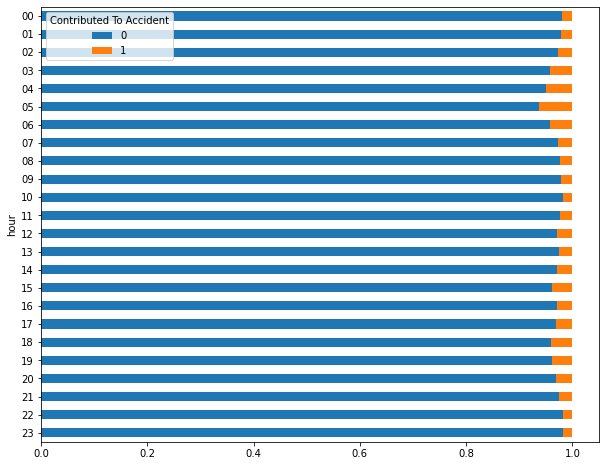

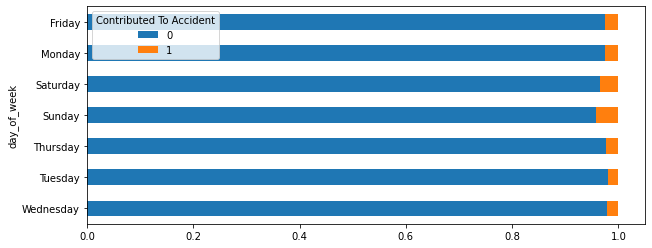

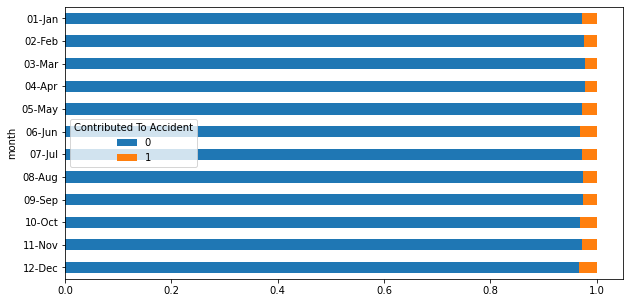

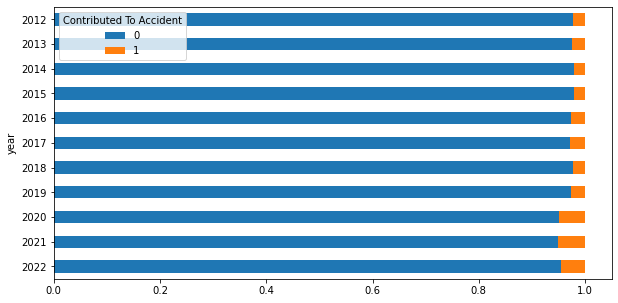

In [11]:
hour.plot.barh(stacked = True, figsize = (10, 8), fontsize = 10)
day_of_week.plot.barh(stacked = True, figsize = (10, 4), fontsize = 10)
month.plot.barh(stacked = True, figsize = (10, 5), fontsize = 10)
year.plot.barh(stacked = True, figsize = (10, 5), fontsize = 10)

In [34]:
observed1 = pd.crosstab(train['day_of_week'], train['Contributed To Accident'])
chi21, p1, degf1, expected1 = stats.chi2_contingency(observed2)

alpha = 0.05
if p1 < alpha:
    print("We reject the null hypothesis, they are dependent.")
else:
    print("We fail to reject the null hypothesis, they are independent.")

We reject the null hypothesis, they are dependent.


### 2. Does contributed to accident relate to race and gender?

<AxesSubplot:ylabel='Race'>

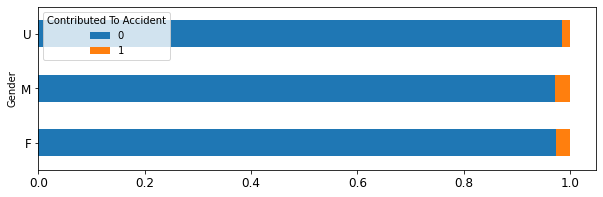

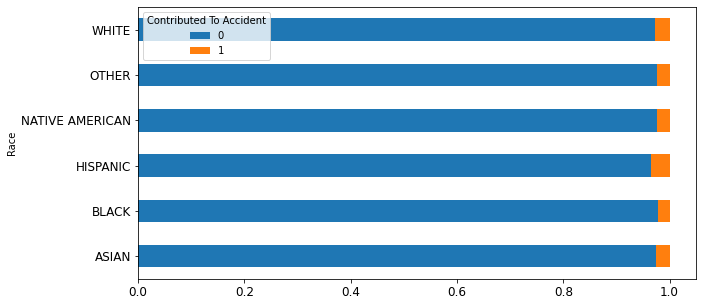

In [12]:
race = pd.crosstab(train.Race, train['Contributed To Accident'], normalize = 'index')
gender = pd.crosstab(train.Gender, train['Contributed To Accident'], normalize = 'index')

gender.plot.barh(stacked = True, figsize = (10, 3), fontsize = 12)
race.plot.barh(stacked = True, figsize = (10, 5), fontsize = 12)

### 3. What about the relationship between contributed to accident and Violation Type? achohol? belts?

<AxesSubplot:ylabel='Belts'>

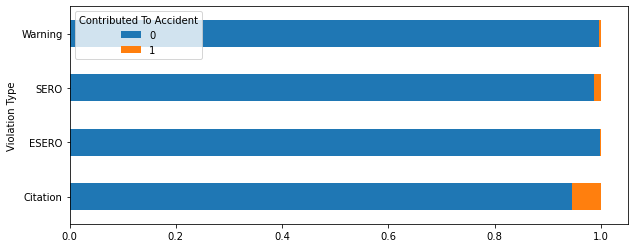

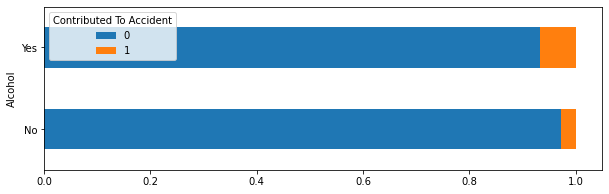

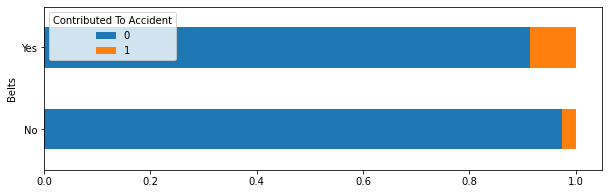

In [13]:
violation = pd.crosstab(train['Violation Type'], train['Contributed To Accident'], normalize = 'index')
alcohol = pd.crosstab(train.Alcohol, train['Contributed To Accident'], normalize = 'index')
belts = pd.crosstab(train.Belts, train['Contributed To Accident'], normalize = 'index')

violation.plot.barh(stacked = True, figsize = (10, 4), fontsize = 10)
alcohol.plot.barh(stacked = True, figsize = (10, 3), fontsize = 10)
belts.plot.barh(stacked = True, figsize = (10, 3), fontsize = 10)

Ho : Violation Type and contributed to accident have no association (they are indepemdent).

Ha : Violation Type injuty and contributed to accident have association (they are depemdent).

In [35]:
observed2 = pd.crosstab(train['Violation Type'], train['Contributed To Accident'])
chi22, p2, degf2, expected2 = stats.chi2_contingency(observed2)

alpha = 0.05
if p2 < alpha:
    print("We reject the null hypothesis, they are dependent.")
else:
    print("We fail to reject the null hypothesis, they are independent.")

We reject the null hypothesis, they are dependent.


Ho : Alcohol and contributed to accident have no association (they are indepemdent).

Ha : Alcohol injuty and contributed to accident have association (they are depemdent).

In [36]:
observed3 = pd.crosstab(train['Alcohol'], train['Contributed To Accident'])
chi23, p3, degf3, expected3 = stats.chi2_contingency(observed2)

alpha = 0.05
if p3 < alpha:
    print("We reject the null hypothesis, they are dependent.")
else:
    print("We fail to reject the null hypothesis, they are independent.")

We reject the null hypothesis, they are dependent.


### 4. Is personal injury has relationship with contributed to accident?

<AxesSubplot:ylabel='Personal Injury'>

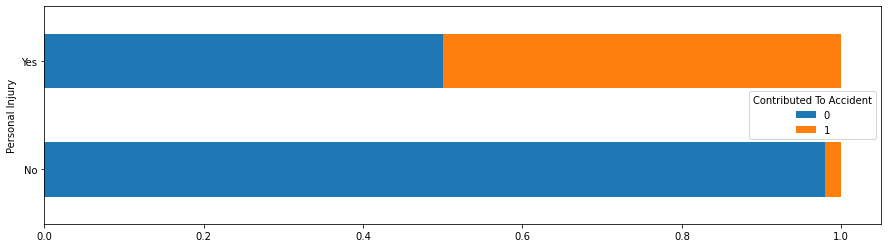

In [14]:
injury = pd.crosstab(train['Personal Injury'], train['Contributed To Accident'], normalize = 'index')
injury.plot.barh(stacked = True, figsize = (15, 4), fontsize = 10)

Ho : Personal injuty and contributed to accident have no association (they are indepemdent).

Ha : Personal injuty and contributed to accident have association (they are depemdent).

In [37]:
observed4 = pd.crosstab(train['Personal Injury'], train['Contributed To Accident'])
chi24, p4, degf4, expected4 = stats.chi2_contingency(observed2)

alpha = 0.05
if p4 < alpha:
    print("We reject the null hypothesis, they are dependent.")
else:
    print("We fail to reject the null hypothesis, they are independent.")

We reject the null hypothesis, they are dependent.


### 5. Is contributed to accident has relationship with property damage?

<AxesSubplot:ylabel='Property Damage'>

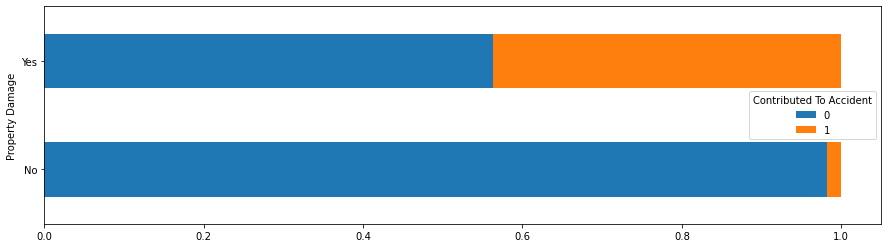

In [15]:
accident = pd.crosstab(train['Property Damage'], train['Contributed To Accident'], normalize = 'index')
accident.plot.barh(stacked = True, figsize = (15, 4), fontsize = 10)

Ho : property damage and contributed to accident have no association (they are indepemdent).

Ha : property damage and contributed to accident have association (they are depemdent).

In [38]:
observed5 = pd.crosstab(train['Property Damage'], train['Contributed To Accident'])
chi25, p5, degf5, expected3 = stats.chi2_contingency(observed3)

alpha = 0.05
if p5 < alpha:
    print("We reject the null hypothesis, they are dependent.")
else:
    print("We fail to reject the null hypothesis, they are independent.")

We reject the null hypothesis, they are dependent.


## Summary

hour, weekday, violation type, alcohol, personal injury, property damage.

## Feature selection

In [34]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

x_train = train[['Alcohol','Violation Type', 'Personal Injury','day_of_week', 'hour','Property Damage']]
y_train = train[['Contributed To Accident']]

x_train_dummy_feature = pd.get_dummies(x_train)
y_train_dummy_feature = pd.get_dummies(y_train, drop_first=True)

In [35]:
kbest = SelectKBest(f_regression, k=10)
kbest.fit(x_train_dummy_feature, y_train_dummy_feature)
x_train_dummy_feature.columns[kbest.get_support()]

Index(['Violation Type_Citation', 'Violation Type_ESERO',
       'Violation Type_Warning', 'Personal Injury_No', 'Personal Injury_Yes',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'hour_05',
       'Property Damage_No', 'Property Damage_Yes'],
      dtype='object')

In [42]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=15)
rfe.fit(x_train_dummy_feature, y_train_dummy_feature)
x_train_dummy_feature.columns[rfe.get_support()]

Index(['hour_00', 'hour_01', 'hour_02', 'hour_07', 'hour_08', 'hour_09',
       'hour_10', 'hour_11', 'hour_13', 'hour_16', 'hour_21', 'hour_22',
       'hour_23', 'Property Damage_No', 'Property Damage_Yes'],
      dtype='object')

## Modeling

metric : Recall (minimizing FN) : TP / (TP+FN)

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [38]:
train['Contributed To Accident'].value_counts()

0    983146
1     26923
Name: Contributed To Accident, dtype: int64

In [42]:
train['baseline'] = 0
baseline_accuracy = (train['Contributed To Accident'] == train.baseline).mean()
print(f'baseline accuracy on train set: {baseline_accuracy:.2%}')

baseline accuracy on train set: 97.33%


In [ ]:
# # split the data and get dummy variables for modeling part

# x_train = train[['Alcohol','Violation Type','Contributed To Accident','hour']]
# y_train = train[['Property Damage']]

# x_validate = validate[['Alcohol','Violation Type','Contributed To Accident','hour']]
# y_validate = validate[['Property Damage']]

# x_test = test[['Alcohol','Violation Type','Contributed To Accident','hour']]
# y_test = test[['Property Damage']]

# x_train_dummy = pd.get_dummies(x_train, drop_first=True)
# x_validate_dummy = pd.get_dummies(x_validate, drop_first=True)
# x_test_dummy = pd.get_dummies(x_test, drop_first=True)

# y_train_dummy = pd.get_dummies(y_train, drop_first=True)
# y_validate_dummy = pd.get_dummies(y_validate, drop_first=True)
# y_test_dummy = pd.get_dummies(y_test, drop_first=True)

In [45]:
# train_dummy = pd.get_dummies(train, drop_first=True)
# validate_dummy = pd.get_dummies(validate, drop_first=True)
# test_dummy = pd.get_dummies(test, drop_first=True)

## 1. Decision Tree

In [ ]:
# use Violation Type, Personal Injury, day_of_week

In [110]:
x_train = train[['Violation Type','Personal Injury','day_of_week','Property Damage','hour']]
y_train = train[['Contributed To Accident']]
x_validate = validate[['Violation Type','Personal Injury','day_of_week','Property Damage','hour']]
y_validate = validate[['Contributed To Accident']]
x_test = validate[['Violation Type','Personal Injury','day_of_week','Property Damage','hour']]
y_test = validate[['Contributed To Accident']]

x_train = pd.get_dummies(x_train, drop_first=True)
y_train = pd.get_dummies(y_train, drop_first=True)
x_validate = pd.get_dummies(x_validate, drop_first=True)
y_validate = pd.get_dummies(y_validate, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)
y_test = pd.get_dummies(y_test, drop_first=True)

In [79]:
# step 1: Creat your recipe
tree = DecisionTreeClassifier(max_depth = 8)

# Step 2: Fit your model to your in-sample data (train)
tree.fit(x_train, y_train)

predictions1 = tree.predict(x_train)

print(classification_report(y_train, predictions1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    983146
           1       0.55      0.19      0.28     26923

    accuracy                           0.97   1010069
   macro avg       0.77      0.59      0.64   1010069
weighted avg       0.97      0.97      0.97   1010069



In [80]:
print('Accuracy of decision tree (max_depth=8) classifier on train set: {:.2%}'
     .format(tree.score(x_train, y_train)))

Accuracy of decision tree (max_depth=8) classifier on train set: 97.43%


In [75]:
metrics = []
for i in range(1, 10):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(x_train, y_train)
    
    out_of_sample_accuracy = tree.score(x_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.973345,0.973346,-0.000001
1,2,0.973353,0.973418,-0.000065
2,3,0.973691,0.973751,-0.000060
3,4,0.973926,0.973880,0.000046
4,5,0.974080,0.973959,0.000121
5,6,0.974132,0.974042,0.000091
6,7,0.974225,0.974097,0.000127
7,8,0.974323,0.974210,0.000112
8,9,0.974426,0.974245,0.000181


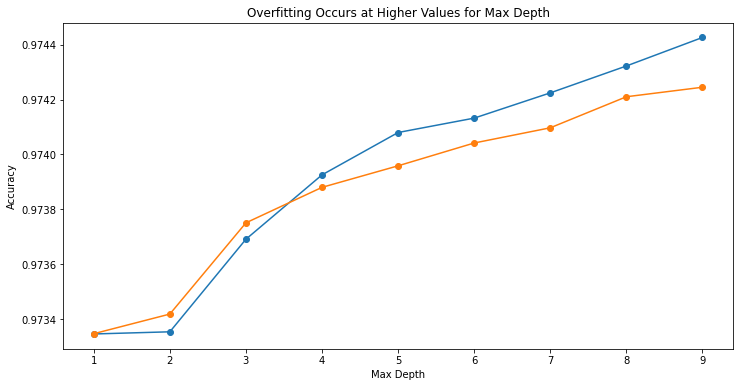

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

* max_depth = 8

## 2. Random forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=11, 
                            min_samples_leaf=4,
                            random_state=123)
rf.fit(x_train, y_train)
predictions2 = rf.predict(x_train)

print(classification_report(y_train, predictions2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    983146
           1       0.69      0.01      0.02     26923

    accuracy                           0.97   1010069
   macro avg       0.83      0.50      0.50   1010069
weighted avg       0.97      0.97      0.96   1010069



In [84]:
print('Accuracy of random forest (max_depth=9) classifier on train set: {:.2%}'
     .format(rf.score(x_train, y_train)))

Accuracy of random forest (max_depth=9) classifier on train set: 97.35%


In [81]:
metrics = []

for i in range(1,15):
    rf = RandomForestClassifier(max_depth=(15-i), 
                            min_samples_leaf=i,
                            random_state=123)
    
    rf = rf.fit(x_train, y_train)
    
    in_sample_accuracy = rf.score(x_train, y_train)
    
    out_of_sample_accuracy = rf.score(x_validate, y_validate)
    
    output = {"max_depth": (15-i),"min_sample_lead" :i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
        
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,min_sample_lead,train_accuracy,validate_accuracy,difference
0,14,1,0.974202,0.973975,0.000227
1,13,2,0.973871,0.973691,0.000180
2,12,3,0.973614,0.973522,0.000092
3,11,4,0.973459,0.973455,0.000004
4,10,5,0.973387,0.973367,0.000020
5,9,6,0.973345,0.973346,-0.000001
6,8,7,0.973345,0.973346,-0.000001
7,7,8,0.973345,0.973346,-0.000001
8,6,9,0.973345,0.973346,-0.000001
9,5,10,0.973345,0.973346,-0.000001


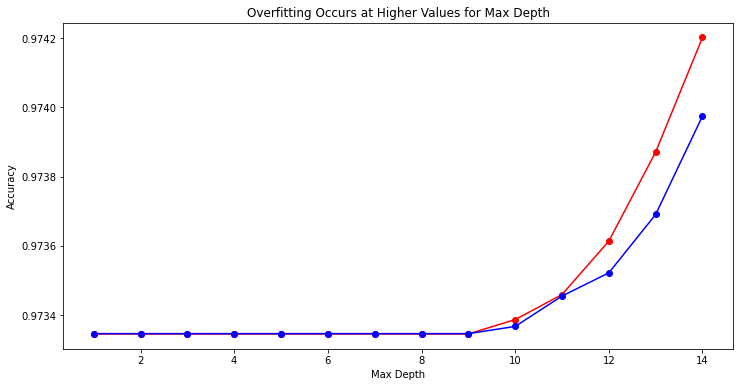

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, color = 'r', marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, color = 'b', marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

* max_depth = 9, leaf = 6

### 3. Logistic Regression

In [85]:
# Define the logistic regression model
logit = LogisticRegression(C=1, random_state=123)

#  fit the model on train data
logit.fit(x_train, y_train)

# now use the model to make predictions
predictions3 = logit.predict(x_train)

print(classification_report(y_train, predictions3))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    983146
           1       0.49      0.24      0.32     26923

    accuracy                           0.97   1010069
   macro avg       0.73      0.62      0.65   1010069
weighted avg       0.97      0.97      0.97   1010069



In [86]:
print('Accuracy of Logistic Regression (c=1) on train set: {:.2%}'
     .format(logit.score(x_train, y_train)))

Accuracy of Logistic Regression (c=1) on train set: 97.30%


In [87]:
print('Accuracy of decision tree (max_depth=6) classifier on train set: {:.2%}'
     .format(tree.score(x_train, y_train)))
print('Accuracy of random forest (max_depth=9) classifier on train set: {:.2%}'
     .format(rf.score(x_train, y_train)))
print('Accuracy of Logistic Regression (c=1) on train set: {:.2%}'
     .format(logit.score(x_train, y_train)))

Accuracy of decision tree (max_depth=6) classifier on train set: 97.43%
Accuracy of random forest (max_depth=9) classifier on train set: 97.35%
Accuracy of Logistic Regression (c=1) on train set: 97.30%


## Validate

In [88]:
# predict on validate
y_pred_tree_validate = tree.predict(x_validate)
y_pred_rf_validate = rf.predict(x_validate)
y_pred_logistic_validate = logit.predict(x_validate)

# evaluate on validate
print('Accuracy of decision tree (max_depth = 8) classifier on validate set: {:.2%}'
     .format(tree.score(x_validate, y_validate)))
print('Accuracy of random forest (max_depth=9) classifier on validate set: {:.2%}'
     .format(rf.score(x_validate, y_validate)))
print('Accuracy of Logistic Regression (c=1) on validate set: {:.2%}'
     .format(logit.score(x_validate, y_validate)))

Accuracy of decision tree classifier on validate set: 97.42%
Accuracy of random forest (max_depth=9) classifier on validate set: 97.35%
Accuracy of Logistic Regression (c=1) on validate set: 97.31%


## Test

In [89]:
# predict on test
y_pred_test = tree.predict(x_test)

# evaluate on test
print('Accuracy of decision tree (max_depth = 8) on test set: {:.2%}'
     .format(tree.score(x_test, y_test)))

Accuracy of decision tree (max_depth = 8) on test set: 97.42%


In [90]:
print(f'baseline accuracy on train set: {baseline_accuracy:.2%}')

baseline accuracy on train set: 97.33%


In [95]:
print(export_text(tree, feature_names=x_test.columns.tolist()))

|--- Property Damage_Yes <= 0.50
|   |--- Personal Injury_Yes <= 0.50
|   |   |--- Violation Type_Warning <= 0.50
|   |   |   |--- Violation Type_ESERO <= 0.50
|   |   |   |   |--- day_of_week_Sunday <= 0.50
|   |   |   |   |   |--- day_of_week_Saturday <= 0.50
|   |   |   |   |   |   |--- hour_18 <= 0.50
|   |   |   |   |   |   |   |--- hour_20 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- hour_20 >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- hour_18 >  0.50
|   |   |   |   |   |   |   |--- day_of_week_Wednesday <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- day_of_week_Wednesday >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- day_of_week_Saturday >  0.50
|   |   |   |   |   |   |--- hour_02 <= 0.50
|   |   |   |   |   |   |   |--- hour_01 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- hour_01 >  0.

In [113]:
# y_test.rename(columns={"Contributed To Accident": "contributed_to_accident"})

In [130]:
from sklearn.tree import plot_tree
# Visualize the tree
plt.figure(figsize=(12, 7))
plot_tree(tree, feature_names=x_test.columns, class_names=y_test.unique())
plt.show()

AttributeError: 'DataFrame' object has no attribute 'unique'

<Figure size 864x504 with 0 Axes>

In [122]:
y_test['Contributed To Accident'].value_counts()

0    421349
1     11538
Name: Contributed To Accident, dtype: int64